# 目录
- 1.背景和研究内容
- 2.构造变量与单变量的预测
- 3.Figure 1  (单变量预测的DCSFE时序图)
- 4.Figure 2  (组合预测的DCSFE时序图)
- 5.Table 1   ($R_{OS}^{2}$与Utility gain)
- 6.组合方法优势的统计解释
  - 6.1 预测涵盖性检验
  - 6.2 预测稳定性
  - 6.3 对比“Kitchen Sink”
- 7.与实际经济的联系
  * 7.1 与商业周期的关系


# 1.背景和研究内容

> Welch and Goyal (2008) find that numerous economic variables with in-sample predictive ability for the equity premium ***fail*** to deliver consistent out-of-sample forecasting gains relative to the historical average.
> Arguing that ***model uncertainty and instability*** seriously impair the forecasting ability of individual predictive regression models, we recommend ***combining individual forecasts***.

**内容**:
- How to combine forecasts?
- Two empirical explanations for the benefits of forecast combination.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
from scipy import stats

# 2.构造变量与单变量的预测

15 variables from Welch and Goyal (2008) for which quarterly data are available for 1947:1–2005:4.

three different out-of-sample forecast evaluation periods:
- 1965:1–2005:4;
- 1976:1–2005:4;
- 2000:1–2005:4.

Campbell and Thompson (2008) 的限制（有先后顺序）：
- 系数符号不对就假设系数为0；
- 预测的权益溢价为负就假设是0。

In [11]:
raw_data = pd.read_excel(os.path.join('数据', 'quaterly_data.xlsx'), index_col=0)
raw_data.tail()

,Index,D3,D12,E3,E12,b/m,tbl,AAA,BAA,lty,...,ntis,Rfree,infl,ltr,corpr,svar,csp,ik,CRSP_SPvw,CRSP_SPvwx
yyyyq,,,,,,,,,,,,,,,,,,,,,
20044,1211.92,5.334,19.440,13.94,58.55,0.260595,0.0219,0.0547,0.0615,0.0484,...,0.013007,0.005025,0.002106,0.016431,0.021671,0.002816,NaN,0.034467,0.091803,0.083486
20051,1180.59,5.345,20.226,16.95,60.32,0.335023,0.0274,0.0540,0.0606,0.0488,...,0.009205,0.006355,0.015765,0.009495,0.003487,0.002516,NaN,0.034646,-0.020251,-0.024754
20052,1191.33,5.364,20.926,18.29,63.36,0.342483,0.0297,0.0496,0.0586,0.0429,...,0.007552,0.007175,0.006208,0.085945,0.078155,0.003227,NaN,0.034748,0.013922,0.009300
20053,1228.81,5.432,21.475,17.39,66.57,0.332964,0.0342,0.0513,0.0603,0.0464,...,0.006060,0.008424,0.022108,-0.030379,-0.032617,0.002007,NaN,0.034910,0.036079,0.031457
20054,1248.29,6.079,22.220,17.29,69.93,0.328341,0.0389,0.0537,0.0632,0.0461,...,0.003736,0.009597,-0.010060,0.014227,0.011557,0.002791,NaN,0.035011,0.022099,0.017180


In [52]:
def construct_variables():
    '''
    构造变量，并保存
    '''
    temp = raw_data.copy()
    #r = np.log(1 + temp['CRSP_SPvw']) - np.log(1 + temp['Rfree'].shift(1))  # 因变量
    r = temp['CRSP_SPvw'] - temp['Rfree']
    
    D_P = np.log(temp['D12']) - np.log(temp['Index'])  # D/P
    D_Y = np.log(temp['D12']) - np.log(temp['Index'].shift(1))  # D/Y
    E_P = np.log(temp['E12']) - np.log(temp['Index'])  # E/P
    D_E = np.log(temp['D12']) - np.log(temp['E12'])  # D/E
    '''
    D_P = temp['D12'] / temp['Index']
    D_Y = temp['D12'] / temp['Index'].shift(1)
    E_P = temp['E12'] / temp['Index']
    D_E = temp['D12'] / temp['E12']
    '''
    TMS = temp['lty'] - temp['tbl']  # TMS
    DFY = temp['BAA'] - temp['AAA']  # DFY
    DFR = temp['corpr'] - temp['ltr']  # DFR
    INFL = temp['infl'].shift(1)  # 直接构造滞后一期的
    result = pd.DataFrame({
        'r': r, 'D/P': D_P, 'D/Y': D_Y, 'E/P': E_P,
        'D/E': D_E, 'SVAR': temp['svar'], 'B/M': temp['b/m'], 'NTIS': temp['ntis'],
        'TBL': temp['tbl'], 'LTY': temp['lty'], 'LTR': temp['ltr'], 'TMS': TMS,
        'DFY': DFY, 'DFR': DFR, 'INFL': INFL, 'I/K': temp['ik']
    })
    result.dropna(inplace=True)
    result.to_csv(os.path.join('中间结果', 'variables.csv'))

construct_variables()

In [2]:
all_data = pd.read_csv(os.path.join('中间结果', 'variables.csv'), index_col=0)
all_data.head()

,r,D/P,D/Y,E/P,D/E,SVAR,B/M,NTIS,TBL,LTY,LTR,TMS,DFY,DFR,INFL,I/K
yyyyq,,,,,,,,,,,,,,,,
19471,-0.002737,-3.047824,-3.056357,-2.480303,-0.567521,0.005718,0.741535,0.050864,0.0038,0.0213,0.003502,0.0175,0.0060,0.004205,0.051768,0.036043
19472,0.010299,-2.996390,-2.993757,-2.357310,-0.639080,0.006663,0.741117,0.046888,0.0038,0.0216,0.000587,0.0178,0.0066,0.003818,0.019952,0.035089
19473,0.003690,-2.951079,-2.957675,-2.277102,-0.673977,0.004086,0.740323,0.044030,0.0080,0.0213,0.009987,0.0133,0.0062,-0.028135,0.004533,0.034053
19474,0.031253,-2.902206,-2.889710,-2.251619,-0.650588,0.002356,0.725326,0.029166,0.0095,0.0243,-0.039832,0.0148,0.0066,0.022582,0.043557,0.034825
19481,-0.003676,-2.875888,-2.890372,-2.176876,-0.699012,0.004842,0.841422,0.027165,0.0100,0.0241,0.010032,0.0141,0.0070,0.007850,0.018767,0.036635


In [3]:
# 三个样本外开始时间点
out = [19651, 19761, 20001]
# 历史均值预测，包含样本内和样本外时间
hist_mean = pd.Series(
    [all_data['r'].iloc[:i].mean() for i in range(len(all_data))],
    index=all_data.index
)

In [4]:
def Single_predict(variable, out_start, restrict=False):
    '''
    所有单变量的样本外预测，不过后面发现也可以用来做多变量，就调整了一下

    Parameters
    ----------
    variable: 变量名  (str)
    out_start: 样本外开始时间  (int yyyyq)
    restrict: 是否施加限制  (bool, default is False)
    '''
    pre = []
    pos = list(all_data.index).index(out_start)
    for i in range(pos, len(all_data)):
        Y = all_data['r'].iloc[1 : i]  # 第一个月的y不能包含进来
        X = all_data[variable].iloc[: (i-1)]
        model = sm.OLS(Y.values, sm.add_constant(X.values)).fit()  # 拟合
        if type(variable) == str:
            pre_i = model.predict([1, all_data[variable].iloc[i - 1]])[0]  # 预测值
        else:
            pre_i = model.predict([1] + all_data[variable].iloc[i - 1].tolist())[0]
        if restrict:  # 若施加限制
            sign = all_data.iloc[:, 1:].apply(
        lambda x: sm.OLS(
            all_data['r'].values,
            sm.add_constant(x.shift(1).values),
            missing='drop'
        ).fit().params[1]
    ) # 计算正确的系数符号
            if (model.params[1] / sign.loc[variable]) > 0:  # 系数符号对
                pass
            else:  # 历史均值预测
                pre_i = (all_data['r'].iloc[:i]).mean()
            if pre_i < 0:
                pre_i = 0
        pre.append(pre_i)
    
    return pd.Series(pre, index=all_data.index[pos:])

In [55]:
# 由于是迭代的窗口，预测时先预测所有时期再根据不同时间窗口取
# 只有采用DMSPE组合预测时才和开始时间有关
# 不施加限制的预测
all_data.iloc[:, 1:].apply(lambda x: Single_predict(x.name, out_start=19551)).to_csv(
    os.path.join('中间结果', '不施加限制.csv')
)

# 施加限制的预测
all_data.iloc[:, 1:].apply(lambda x: Single_predict(x.name, out_start=19551, restrict=True)).to_csv(
    os.path.join('中间结果', '施加限制.csv')
)

In [5]:
all_result = pd.read_csv(os.path.join('中间结果', '不施加限制.csv'), index_col=0)  # 所有日期的结果
all_result_res = pd.read_csv(os.path.join('中间结果', '施加限制.csv'), index_col=0)  # 施加限制的所有日期的结果

# 3.Figure 1
>Cumulative square prediction error for the historical average benchmark forecasting model minus the cumulative square prediction error for the individual predictive regression forecasting model, 1965:12005:4.  
The dotted (solid) line corresponds to individual model forecasts that (do not) impose Campbell and Thompson (2008) restrictions.

In [8]:
def DCSFE_plot(prediction1, prediction2):
    '''
    作出DCSFE时序图

    Parameters
    ----------
    prediction1: 不施加约束的预测结果  (pd.DataFrame)
    prediction2: 施加约束的预测结果  (pd.DataFrame)
    '''
    out_start = prediction1.index[0]
    true_ret = all_data['r'].loc[out_start:]
    hist_mean1 = hist_mean.loc[out_start:]
    hist_mean_FE = true_ret - hist_mean1  #历史均值预测的误差
    hist_mean_CSFE = (hist_mean_FE ** 2).cumsum()  #历史均值的累计平方误差
    prediction1_CSFE = prediction1.apply(lambda x: ((true_ret - x) ** 2).cumsum())  #预测模型的累计平方误差
    prediction2_CSFE = prediction2.apply(lambda x: ((true_ret - x) ** 2).cumsum())  #施加限制的的累计平方误差

    #作图
    temp1 = prediction1_CSFE.apply(lambda x: hist_mean_CSFE - x)
    temp2 = prediction2_CSFE.apply(lambda x: hist_mean_CSFE - x)
    # 只需要实现两幅图，因此这里加了一个简单的条件判断
    if len(prediction1.columns) == 15:
        r, c = (4, 4)
    elif len(prediction1.columns) == 5:
        r, c = (2, 3)
    plt.figure(figsize=(20, 15))
    for i in range(1, len(prediction1.columns) + 1):
        plt.subplot(r, c, i)
        plt.plot(temp1.index, temp1.iloc[:, i - 1])
        plt.plot(temp2.index, temp2.iloc[:, i - 1], linestyle='dashed')
        plt.title(temp1.columns[i - 1])
        plt.ylim(-0.1, 0.1)
        plt.xlim(temp1.index[0], temp1.index[-1])
        plt.hlines(y=0, xmin=temp1.index[0], xmax=temp1.index[-1])

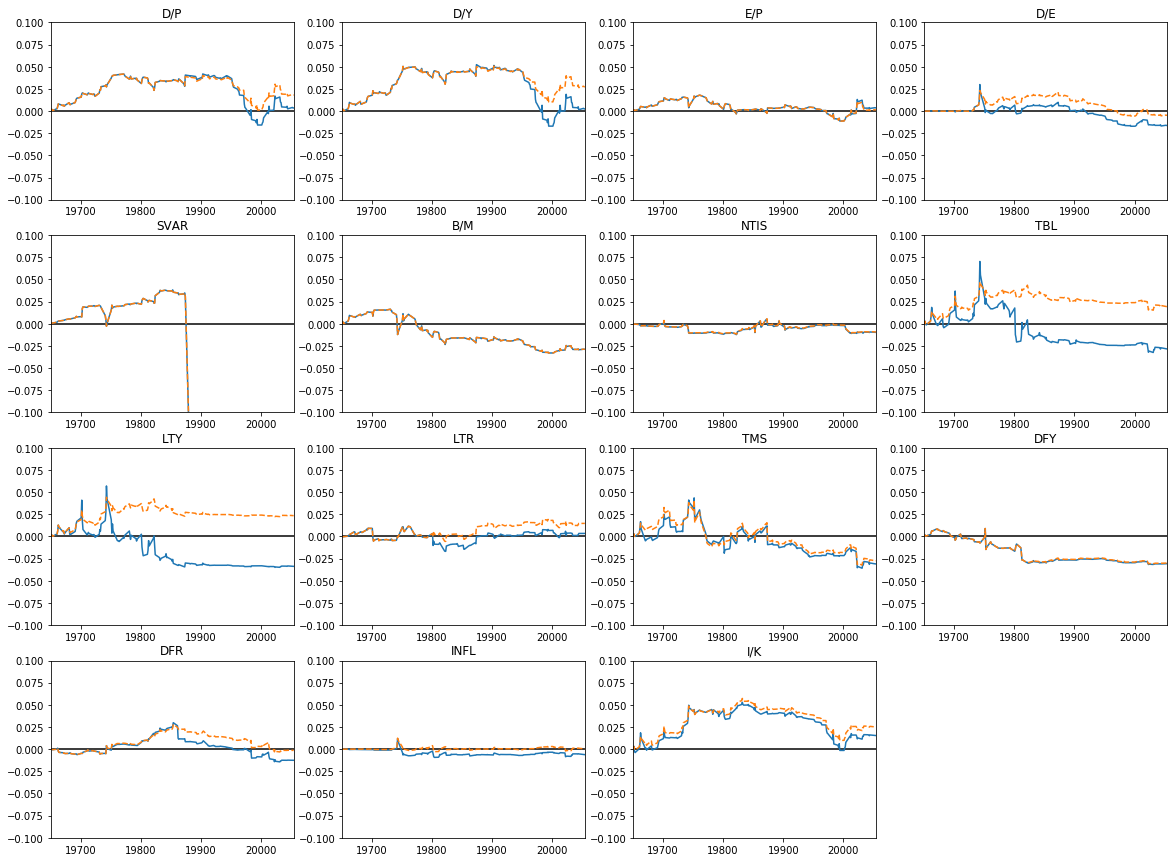

In [57]:
DCSFE_plot(all_result.loc[out[0]:].copy(), all_result_res.loc[out[0]:].copy())

# 4.Figure 2
>Cumulative square prediction error for the historical average benchmark forecasting model minus the cumulative square prediction error for the combination forecasting model, 1965:1-2005:4.  
The dotted (solid) line corresponds to combination forecasts based on individual model forecasts that (do not) impose Campbell and Thompson (2008) restrictions.

组合方式有：
- 简单组合：
  - mean;
  - median;
  - trimmed mean: 去掉最大值、最小值之后再平均.
- holdout区间上(40个季度)的表现加权 (discount mean square prediction error (DMSPE))：
  - DMSPE(1.0);
  - DMSPE(0.9)

$$\omega _{i,t}=\Phi_{i,t}^{-1}/\sum_{j=1}^{N}\Phi_{j,t}^{-1}$$

其中：

$$\Phi _{i, t}=\sum_{s=m}^{t-1}\theta ^{t-1-s}\left ( r_{s+1}-\widehat{r}_{i,s+1} \right )^{2}$$

In [10]:
def PB_combination(prediction, theta):
    '''
    基于MSPE的组合预测，返回组合预测结果
    输入的预测前40行是hold-out窗口

    Parameters
    ----------
    prediction: 输入的单变量预测  (pd.DataFrame)
    theta: 折现因子  (float)

    Returns
    -------
    组合结果  (pd.Series)
    '''
    pre = []
    SPE = prediction.apply(
        lambda x: (all_data['r'].loc[prediction.index] - x) ** 2
    )  # 所有单变量预测每期的SPE
    for i in range(40, len(prediction)):
        esti_window = SPE.iloc[:i, :]  # 权重估计窗口
        Theta = pd.Series([theta ** s for s in range(i-1, -1, -1)], index=esti_window.index)  # 每期折现因子
        # 单变量的权重
        phi = SPE.apply(lambda x: (x * Theta).sum())
        wi = 1 / phi
        wi = wi / wi.sum()
        pre.append((wi * prediction.iloc[i, :]).sum())
    
    return pd.Series(pre, index=prediction.index[40:])

In [11]:
def Forecast_combination(prediction, out_start):
    '''
    组合预测，返回组合预测结果
    'Mean', 'Median', 'Trimmed mean', DMSPE(1.0), DMSPE(0.9)

    Parameters
    ----------
    prediction: 施加限制或不施加限制的预测结果  (pd.DataFrame)
    out_start: 样本外开始窗口，要包含hold-out区间  (int yyyyq)

    Returns
    -------
    组合预测结果  (pd.DataFrame)
    '''
    result = pd.DataFrame()
    result['DMSPE(1.0)'] = PB_combination(prediction.loc[out_start:], 1.0)
    result['DMSPE(0.9)'] = PB_combination(prediction.loc[out_start:], 0.9)
    result['Mean'] = prediction.mean(axis=1).loc[result.index]
    result['Median'] = prediction.median(axis=1).loc[result.index]
    result['Trimmed mean'] = prediction.apply(
        lambda x: np.sort(x)[1:-1].mean(),
        axis=1
    ).loc[result.index]
    # 调整顺序
    result = result[['Mean', 'Median', 'Trimmed mean', 'DMSPE(1.0)', 'DMSPE(0.9)']]

    return result

In [ ]:
# 区间1组合预测
Forecast_combination(all_result, 19551).to_csv(os.path.join('中间结果', '区间1不施加限制组合.csv'))
Forecast_combination(all_result_res, 19551).to_csv(os.path.join('中间结果', '区间1施加限制组合.csv'))

In [7]:
FC_out1 = pd.read_csv(os.path.join('中间结果', '区间1不施加限制组合.csv'), index_col=0)
FC_out1_res = pd.read_csv(os.path.join('中间结果', '区间1施加限制组合.csv'), index_col=0)

In [14]:
FC_out1.head()

,Mean,Median,Trimmed mean,DMSPE(1.0),DMSPE(0.9)
yyyyq,,,,,
19651,0.020352,0.020225,0.020918,0.019975,0.020380
19652,0.018920,0.019491,0.019607,0.018503,0.018944
19653,0.018058,0.018441,0.019344,0.017619,0.017664
19654,0.019328,0.020838,0.020197,0.019010,0.019538
19661,0.016812,0.018582,0.017501,0.016432,0.017155


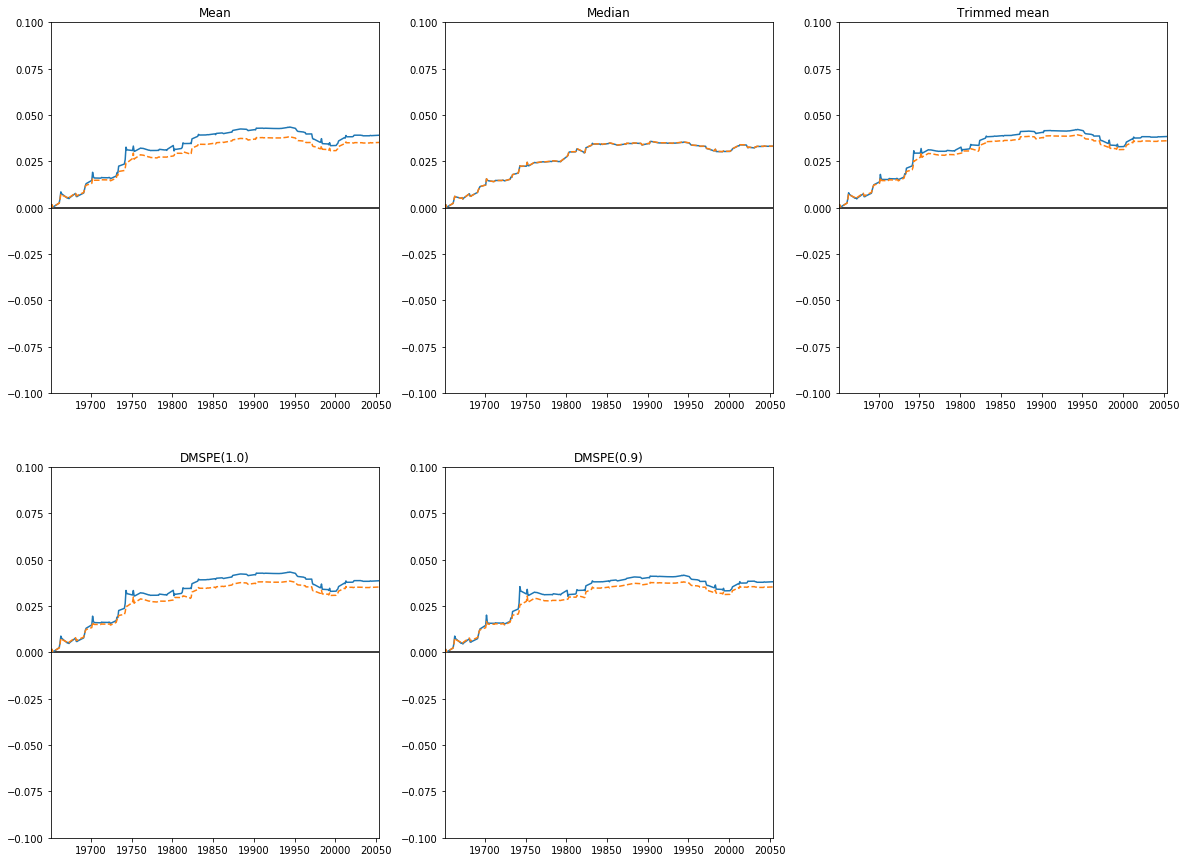

In [15]:
DCSFE_plot(FC_out1, FC_out1_res)

# 5.Table 1

各个预测的样本外R2、对应p值以及效用增益

In [8]:
def OOS_R2(prediction, benchmark, true_ret):
    '''
    计算样本外R方及对应的CW-test

    Parameters
    ----------
    prediction: 超额收益预测的时间序列  (pd.Series)
    benchmark: 比较的基准  (pd.Series)
    true_ret: 真实值  (pd.Series)

    Returns:
    --------
    样本外R方  (float)
    p值  (float)
    '''
    MSFE_M = ((prediction - true_ret) ** 2).mean()  #预测值的MSFE
    MSFE_bmk = ((benchmark - true_ret) ** 2).mean()  #基准的MSFE
    R2_OOS = 1 - MSFE_M / MSFE_bmk
    #CW-test
    f = (true_ret - benchmark) ** 2 - (true_ret - prediction) ** 2 + (benchmark - prediction) ** 2
    t_stat, p_value = stats.ttest_1samp(f, 0)
    if t_stat > 0:
        p_value = p_value / 2
    else:
        p_value = 1 - p_value / 2
    if p_value < 0.01:
        signif = '***'
    elif p_value < 0.05:
        signif = '**'
    elif p_value < 0.1:
        signif = '*'
    else:
        signif = None

    return round(R2_OOS * 100, 2), signif

In [9]:
# 计算效用增益
Variance_hat = all_data['r'].rolling(window=40).apply(
    lambda x: (x ** 2).mean() - (x.mean()) ** 2
).shift(1)  # 所有期限的方差估计

def CER(prediction, gamma=3, weight_bound=[0, 1.5]):
    '''
    return the certainty equivalent return of one prediction

    Parameters
    ----------
    prediction: prediction of stock market returns.  (pd.Series)
    gamma: relative risk aversion parameter, default 3.  (float)
    weight_bound: the weight bound on stocks,
                  weight_bound[0] is the lower bound,
                  weight_bound[1] is the upper bound.  (list)
    
    Returns
    -------
    CER.  (float)
    '''
    variance_hat = Variance_hat.loc[prediction.index]
    rf_rate = (raw_data['Rfree'].shift(1)).loc[prediction.index]
    true_ret = all_data['r'].loc[prediction.index]
    # weights on stocks
    weights = 1 / gamma * (prediction / variance_hat)
    # weights constrain
    weights.clip(weight_bound[0], weight_bound[1], inplace=True)
    # portfolio return
    ret = weights * true_ret + rf_rate
    CER_M = ret.mean() - 0.5 * gamma * ret.var()

    return CER_M

def Utility_gain(prediction, **kwds):
    '''
    计算效用增益
    
    Parameters
    ----------
    prediction: 预测结果  (pd.Series)

    Returns
    -------
    效用增益  (float)
    '''
    hist = hist_mean.loc[prediction.index]

    return round(400 * (CER(prediction=prediction, **kwds) - CER(prediction=hist, **kwds)), 2)

先展示一下利用*一样的*算法，复制rapach excel表的结果：

![复制Rapach R2.png](https://i.loli.net/2020/03/31/aAoxGMVb1BL5yq8.png)

![复制rapach CER.png](https://i.loli.net/2020/03/31/FU4YOqNR5hftQTv.png)

***结果基本完全一样***

## Panel A: 1965:1 - 2005:4

In [12]:
# 施加限制的预测的平均组合
Mean_CT = all_result_res.mean(axis=1)

show_table1_A = pd.concat([all_result, FC_out1], axis=1, join='inner')
show_table1_A['Mean CT'] = Mean_CT.loc[show_table1_A.index]

def Show_table1(table1):
    '''
    展示Table1

    Parameters
    ----------
    table1: 某一区间内所有预测结果  (pd.DataFrame)
    '''

    temp = pd.concat(
        [
            table1.apply(OOS_R2, benchmark=hist_mean.loc[table1.index], true_ret=all_data['r'].loc[table1.index]),
            table1.apply(Utility_gain)
        ],
        axis=1
    )

    return temp

Show_table1(show_table1_A)

,0,1
D/P,"(0.31, *)",0.55
D/Y,"(0.21, *)",1.42
E/P,"(0.33, None)",0.63
D/E,"(-1.46, None)",0.59
SVAR,"(-12.83, **)",0.10
B/M,"(-2.58, None)",-0.61
NTIS,"(-0.87, None)",0.08
TBL,"(-2.55, **)",2.63
LTY,"(-3.02, None)",2.30
LTR,"(0.31, None)",1.29


## Panel B: 19761:20054

In [22]:
# 区间2不施加限制的组合预测
Forecast_combination(all_result, 19661).to_csv(os.path.join('中间结果', '区间2不施加限制组合.csv'))

In [23]:
FC_out2 = pd.read_csv(os.path.join('中间结果', '区间2不施加限制组合.csv'), index_col=0)
show_table1_B = pd.concat([all_result, FC_out2], axis=1, join='inner')
show_table1_B['Mean CT'] = Mean_CT.loc[show_table1_B.index]
Show_table1(show_table1_B)


,0,1
D/P,"(-5.05, None)",-0.72
D/Y,"(-6.19, None)",-0.56
E/P,"(-1.7, None)",0.73
D/E,"(-2.25, None)",-1.64
SVAR,"(-22.22, **)",0.05
B/M,"(-4.69, None)",-1.29
NTIS,"(0.13, None)",0.60
TBL,"(-7.07, None)",-0.80
LTY,"(-5.48, None)",-0.87
LTR,"(-0.27, None)",1.43


## Panel C: 20001:20054

In [45]:
# 区间3不施加限制的组合预测
Forecast_combination(all_result, 19901).to_csv(os.path.join('中间结果', '区间3不施加限制组合.csv'))

In [24]:
FC_out3 = pd.read_csv(os.path.join('中间结果', '区间3不施加限制组合.csv'), index_col=0)
show_table1_C = pd.concat([all_result, FC_out3], axis=1, join='inner')
show_table1_C['Mean CT'] = Mean_CT.loc[show_table1_C.index]
Show_table1(show_table1_C)

,0,1
D/P,"(10.22, *)",12.92
D/Y,"(10.3, *)",12.95
E/P,"(7.95, None)",9.52
D/E,"(0.5, None)",0.46
SVAR,"(-5.64, None)",-1.65
B/M,"(2.25, None)",3.07
NTIS,"(-4.15, None)",1.30
TBL,"(-2.39, None)",-0.21
LTY,"(-0.32, None)",0.24
LTR,"(-1.77, None)",2.56


# 6.组合方法优势的统计解释

## 6.1 预测涵盖性检验(Table 2)
思想：如果发现不同变量之间的预测无法互相涵盖，则有动机把预测组合起来



In [31]:
def encompassing_test(pre1, pre2):
    '''
    Forecast encompassing test with the null that pre1 encompasses pre2.
    
    Parameters
    ----------
    pre1: Prediction_i.  (pd.Series)
    pre2: Prediction_j.  (pd.Series)

    Returns
    -------
    P-value of the test.  (float)
    '''
    #forecast error
    true_ret = all_data['r'].loc[pre1.index]
    out_num = len(pre1)
    FE1 = true_ret - pre1
    FE2 = true_ret - pre2
    
    g = (FE1 - FE2) * FE1
    g_bar = g.mean()
    V_hat = (1 / out_num**2) * sum((g - g_bar) ** 2)
    HLN = out_num / (out_num - 1) * (V_hat ** (-0.5)) * g_bar

    #return p-value according to t_(out_num - 1)
    return (1 - stats.t(df=(out_num-1)).cdf(HLN))

def encompassing_result(prediction):
    '''
    Matrix for test.
    The entries represent the p-value of the null that column variable encompass row viable.

    Parameters
    ----------
    prediction: Prediction results of different models.  (pd.DataFrame)

    Returns
    -------
    test resuls.  (pd.DataFrame)
    '''
    model_names = prediction.columns
    result = []
    for model_i in model_names:
        model_i_result = []
        for model_j in model_names:
            if model_i == model_j:
                model_i_result.append(1)
            else:
                model_i_result.append(encompassing_test(prediction[model_i], prediction[model_j]))
        
        result.append(model_i_result)
    
    result = pd.DataFrame(
    result,
    index=model_names,
    columns=model_names
).T

    return result.round(2)

In [50]:
encompassing_result(show_table1_A.iloc[:, :-1])

,D/P,D/Y,E/P,D/E,SVAR,B/M,NTIS,TBL,LTY,LTR,TMS,DFY,DFR,INFL,I/K,Mean,Median,Trimmed mean,DMSPE(1.0),DMSPE(0.9)
D/P,1.00,0.50,0.11,0.02,0.13,0.02,0.02,0.00,0.01,0.03,0.00,0.01,0.02,0.03,0.02,0.36,0.30,0.39,0.35,0.33
D/Y,0.23,1.00,0.09,0.02,0.12,0.02,0.01,0.00,0.01,0.02,0.00,0.01,0.01,0.03,0.02,0.28,0.24,0.31,0.28,0.27
E/P,0.50,0.45,1.00,0.04,0.15,0.02,0.05,0.01,0.02,0.09,0.00,0.03,0.06,0.12,0.05,0.69,0.69,0.73,0.68,0.65
D/E,0.15,0.16,0.15,1.00,0.15,0.04,0.09,0.02,0.04,0.19,0.01,0.06,0.13,0.35,0.25,0.86,0.78,0.86,0.86,0.86
SVAR,0.02,0.03,0.02,0.02,1.00,0.00,0.01,0.00,0.01,0.02,0.00,0.00,0.01,0.03,0.01,0.26,0.11,0.13,0.25,0.24
B/M,0.71,0.66,0.85,0.11,0.17,1.00,0.16,0.01,0.02,0.22,0.02,0.16,0.19,0.25,0.12,0.79,0.82,0.82,0.78,0.75
NTIS,0.14,0.15,0.21,0.06,0.16,0.03,1.00,0.01,0.01,0.22,0.01,0.06,0.11,0.22,0.05,0.75,0.74,0.76,0.74,0.73
TBL,0.02,0.02,0.02,0.04,0.08,0.01,0.02,1.00,0.14,0.04,0.01,0.01,0.02,0.04,0.22,0.20,0.14,0.19,0.20,0.20
LTY,0.08,0.08,0.07,0.12,0.10,0.02,0.05,0.27,1.00,0.09,0.01,0.02,0.05,0.13,0.23,0.38,0.30,0.38,0.39,0.39
LTR,0.06,0.07,0.07,0.07,0.14,0.01,0.07,0.01,0.02,1.00,0.01,0.02,0.03,0.13,0.06,0.51,0.45,0.51,0.50,0.50


>The frequent inability of individual predictive regression model forecasts to encompass forecasts from other individual models stands out in Table 2.  
The combination forecasts are able to encompass the forecasts from the individual predictive regression models and other combining methods.

## 6.2 预测稳定性(Forecast Stabilization)
思想：类似在投资组合中加入资产可以减少方差（对冲），将预测结合起来也可以降低预测结果的方差。根据：
$$MSPE\approx \left ( \bar{\hat{r}}-\bar{r} \right )^{2}+\sigma _{\hat{r}}^{2}+\sigma _{r}^{2}$$
若能减小预测结果的方差（第二项）且平方预测偏误（第一项）不会提高太多，则MSPE会减小，从而R2变大

下面是各个预测结果的时序图（论文Figure 3），虚线代表历史均值预测，右下角是平均预测，可以看到平均之后波动明显变小


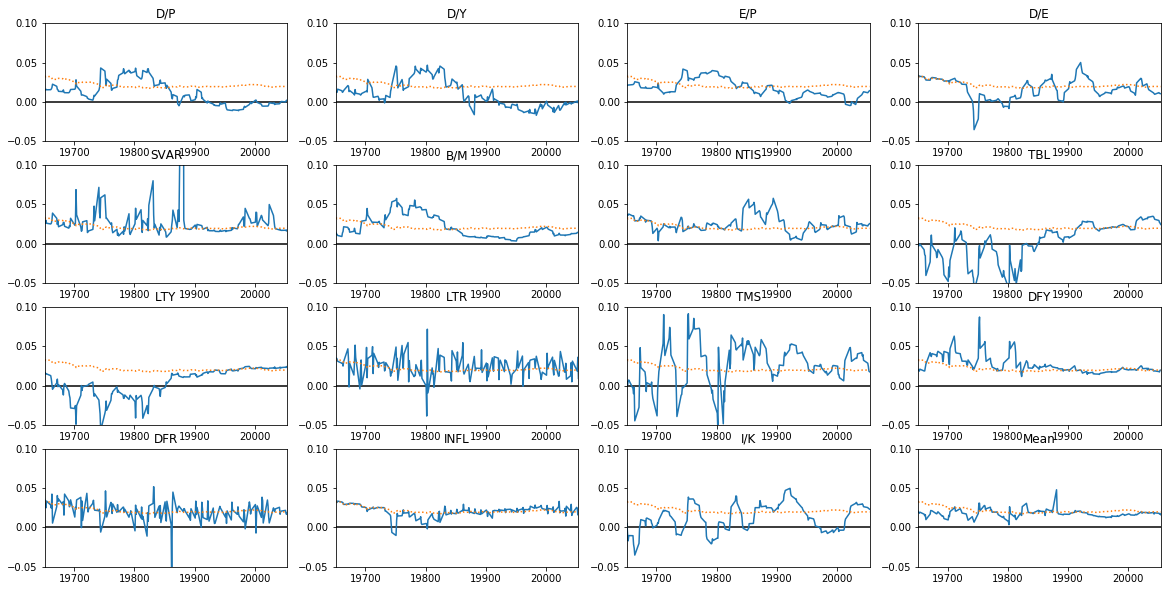

In [14]:
def Figure2():
    '''
    作出Figure 2
    '''
    plt.figure(figsize=(20, 10))
    for i in range(1, 17):
        plt.subplot(4, 4, i)
        plt.plot(show_table1_A.index, show_table1_A.iloc[:, i-1])
        plt.plot(show_table1_A.index, hist_mean.loc[show_table1_A.index], linestyle='dotted')
        plt.hlines(y=0, xmin=show_table1_A.index[0], xmax=show_table1_A.index[-1])
        plt.ylim(-0.05, 0.1)
        plt.xlim(show_table1_A.index[0], show_table1_A.index[-1])
        plt.title(show_table1_A.columns[i-1])

Figure2()

再以平方预测偏差为x轴，以预测方差为y轴作散点图验证（论文Figure 4）：

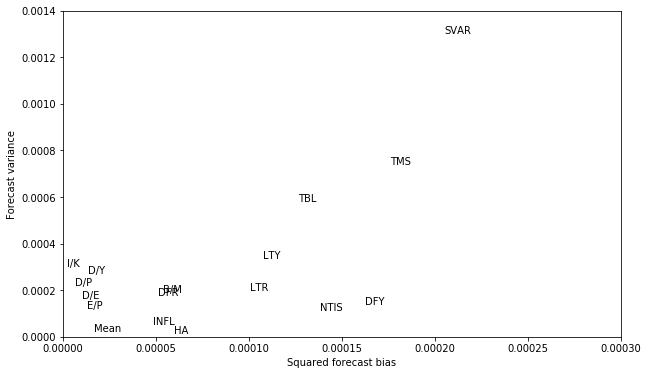

In [76]:
def Figure4():
    '''
    作出Figure 4
    '''
    temp = show_table1_A.copy().iloc[:, :16]  # 组合预测只包含平均值
    temp['HA'] = hist_mean.loc[temp.index]  # 加入历史均值预测
    SFB = (temp.mean() - (all_data['r'].loc[temp.index]).mean()) ** 2  # 平方预测偏误
    FC = temp.var()  # 预测方差
    #plt.scatter(SFB, FC)
    plt.figure(figsize=(10, 6))
    for model in temp.columns:
        plt.text(
            SFB.loc[model],
            FC.loc[model],
            model
        )
    plt.xlim(0, 3 * 10 ** (-4))
    plt.ylim(0, 1.4 * 10 ** (-3))
    plt.xlabel('Squared forecast bias')
    plt.ylabel('Forecast variance')

Figure4()

>The mean combination forecast has a lower forecast variance than all of the individual predictive regression models.  
The mean combination forecast has a relatively small squared forecast bias, close to the smallest squared biases of the individual predictive regression models.

## 6.3 "Kitchen Sink"模型
这也是一种同时利用15个经济变量的方式：
$$r_{t+1}=\alpha ^{KS}+\beta _{1}^{KS}x_{1,t}+...+\beta _{N}^{KS}x_{N,t}+\varepsilon _{t+1}$$
发现这种方式表现很差，这里分析原因  
首先计算这种方式在三段样本外区间的R2，论文中分别为-19.35%, -35.50%, -2.29%

In [13]:
# 样本外区间的预测
# 同样只需要做最长区间的预测，其他区间的索引就行
KS1 = Single_predict(all_result.columns, out_start=out[0])
KS2 = KS1.loc[out[1]:]
KS3 = KS1.loc[out[2]:]

In [88]:
# 三个区间的样本外R2
[print(OOS_R2(x, hist_mean.loc[x.index], all_data['r'].loc[x.index])[0]) for x in [KS1, KS2, KS3]]

-19.04
-34.97
-2.27


[None, None, None]

### 理论分析：
demean处理之后得到：
$$\hat{r}_{t+1}^{KS}=\bar{r}+\sum_{i=1}^{N}\hat{\beta }_{i}^{KS}(x_{i,t}-\bar{x}_{i})$$
共线性会导致数值求解不准确，若施加限制a: *各变量是正交的*，此时各个系数的估计会等于单变量回归得到的估计。  
若再施加预测b：
$$\beta _{i}^{KS}=\frac{1}{N}\beta _{i}, i=1,\cdots ,N.$$
此时预测值就是单变量预测值的简单平均。

#### 直觉解释：
考虑双变量预测的情况，预测结果分别是$\bar{r}+0.02$, $\bar{r}+0.04$，“Kitchen Sink”给出的预测会是$\bar{r}+0.06$，而平均组合方式的预测为$\bar{r}+0.03$，平均组合法有***向历史平均收缩的趋势***。  

下图的预测结果走势很好地体现了这种趋势（论文Figure 5）：

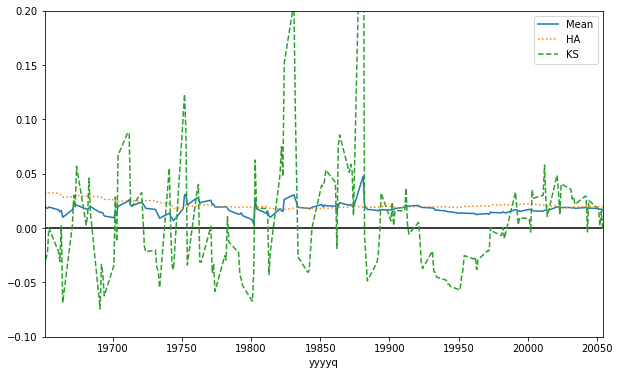

In [16]:
def Figure5():
    '''
    作出Figure 5
    '''
    plt.figure(figsize=(10, 6))
    show_table1_A['Mean'].plot(label='Mean')
    hist_mean.loc[show_table1_A.index].plot(linestyle='dotted', label='HA')
    KS1.plot(linestyle='dashed', label='KS')
    plt.hlines(y=0, xmin=show_table1_A.index[0], xmax=show_table1_A.index[-1])
    plt.legend()
    plt.ylim(-0.1, 0.2)

Figure5()

可以看到“Kitchen Sink”的方差非常大

# 7.和实际经济的联系(Links to the Real Economy)

## 7.1 与商业周期的关系
>Fama and French (1989) and Cochrane (1999, 2007) argue that heightened risk aversion during economic downturns demands a higher risk premium, thereby generating equity premium predictability.

因此看一下组合预测的结果是否有这样的规律，下图(论文Figure 6)中实线代表组合预测的结果，虚线代表历史均值预测，P代表Peak，T代表Trough.

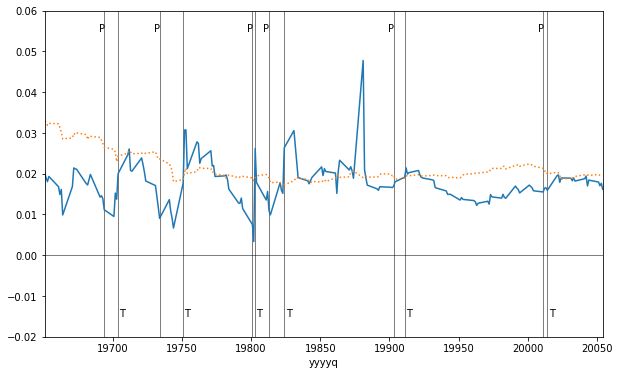

In [23]:
def Figure6():
    '''
    作出Figure 6
    '''
    Peak = [19694, 19734, 19801, 19813, 19903, 20011]
    Trough = [19704, 19751, 19803, 19824, 19911, 20014]
    plt.figure(figsize=(10, 6))
    show_table1_A['Mean'].plot()
    hist_mean.loc[show_table1_A.index].plot(linestyle='dotted')
    plt.ylim(-0.02, 0.06)
    plt.xlim(show_table1_A.index[0], show_table1_A.index[-1])
    for p in Peak:
        plt.vlines(p, -0.02, 0.06, linewidth=0.5)
        plt.text(p-4, 0.055, 'P')
    for t in Trough:
        plt.vlines(t, -0.02, 0.06, linewidth=0.5)
        plt.text(t+1, -0.015, 'T')
    plt.hlines(0, show_table1_A.index[0], show_table1_A.index[-1], linewidth=0.5)

Figure6()

关于历史均值预测的缺点，论文里面这么说：
>From an economic perspective, the “problem” with the historical average forecast is that it ignores business-cycle fluctuations and thus fails to incorporate meaningful macroeconomic information.

后文更深入的分析主要是在讨论经济联系。